In [38]:
import torch
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import os
from PIL import Image
from dataloader import PairedDataset
from model import NST
from lossnet import VGG
from trainer import train_NST, make_grid, save_image
from encoder import print_trainable_parameters

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
torch.manual_seed(324)
torch.cuda.manual_seed(324)
np.random.seed(324)
random.seed(324)
# dataloader
content_dir = "/data/louis/NST_dataset/COCO2014/"
style_dir = "/data/louis/NST_dataset/WikiArt_processed/"
train_dataset = PairedDataset(content_dir, style_dir, crop = False, norm = True, mode='train')
val_dataset = PairedDataset(content_dir, style_dir, crop = False, norm = True, mode='val')
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
# lora config
lora_config_c = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value", "key"],
    lora_dropout=0.1,
    bias="none",
)
lora_config_s = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value", "key"],
    lora_dropout=0.1,
    bias="none",
)

In [3]:
model = NST(encoder_num_layers=6, decoder_num_layers=3, freeze=True)
model.encoder_c = get_peft_model(model.encoder_c, lora_config_c)
model.encoder_s = get_peft_model(model.encoder_s, lora_config_s)
model.load_state_dict(torch.load("/data/louis/NST_checkpoint/NST_30th_jointly_training_best.pth", map_location=device))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


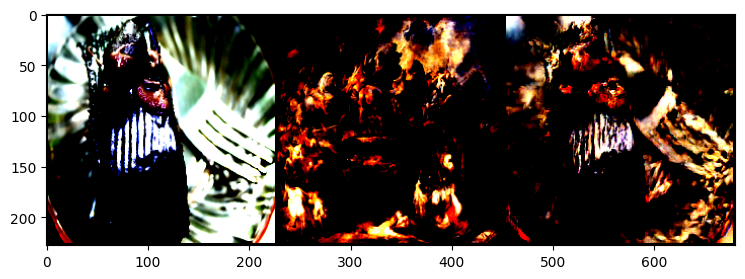

In [5]:
model.eval()
with torch.no_grad():
    contents, styles = next(iter(val_dataloader))
    gens = model(contents, styles)
    imag_stack = torch.vstack([contents, styles, gens])
    imag_grid = make_grid(imag_stack, nrow=3)
    plt.figure(figsize=(10,3))
    plt.imshow(imag_grid.permute(1,2,0))

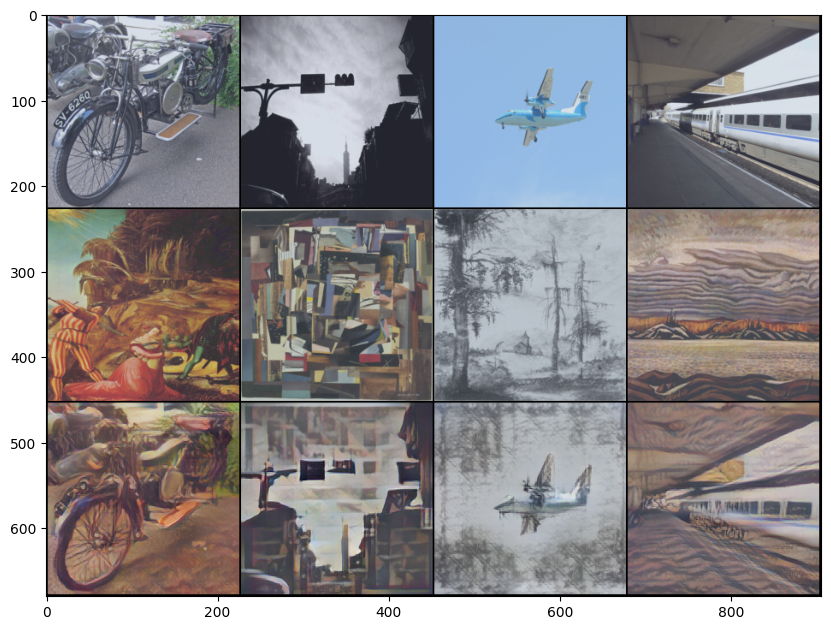

In [6]:
from torchvision.transforms import transforms
from PIL import Image
transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

paths_c = [
    '/data/louis/NST_dataset/COCO2014/val/COCO_val2014_000000000073.jpg',
    '/data/louis/NST_dataset/COCO2014/val/COCO_val2014_000000000359.jpg',
    '/data/louis/NST_dataset/COCO2014/val/COCO_val2014_000000213412.jpg',
    '/data/louis/NST_dataset/COCO2014/val/COCO_val2014_000000352491.jpg'
]

paths_s = [
    '/data/louis/NST_dataset/WikiArt_processed/val/albrecht-altdorfer_beheading-of-st-catherine-1506.jpg',
    '/data/louis/NST_dataset/WikiArt_processed/val/ad-reinhardt_collage-1940.jpg', 
    '/data/louis/NST_dataset/WikiArt_processed/val/albrecht-altdorfer_alpine-landscape-with-church-1522.jpg',
    '/data/louis/NST_dataset/WikiArt_processed/val/a.y.-jackson_algoma-in-november-1935.jpg'
]

def val_selected_images(model, paths_c, paths_s, transform):
    contents = []
    styles = []
    num_selected = len(paths_c)
    for file_c, file_s in zip(paths_c, paths_s):
        content_imag = Image.open(file_c).convert("RGB")
        Ic = transform(content_imag)
        contents.append(Ic)
        style_imag = Image.open(file_s).convert("RGB")
        Is = transform(style_imag)
        styles.append(Is)
    contents = torch.stack(contents, dim=0)
    styles = torch.stack(styles, dim=0)
    gens = model(contents, styles)
    img_stack = torch.vstack([contents, styles, gens])
    img_grid = make_grid(img_stack, normalize=True, nrow=num_selected)
    # writer.add_image(
    #     "Contents/Styles/Generated", img_grid, global_step=val_step
    # )
    return img_grid

imag_grid = val_selected_images(model, paths_c=paths_c, paths_s=paths_s, transform=transform)
plt.figure(figsize=(10,10))
plt.imshow(imag_grid.permute(1,2,0))

In [4]:
from torch import nn
def inference(model, content_path, style_path, device):
    # load images
    content_imag = transforms.ToTensor()(Image.open(content_path).convert("RGB"))
    style_imag = transforms.ToTensor()(Image.open(style_path).convert("RGB"))
    # calculate input standard size, since the input should be square images and size should be a multiple of 16
    _, Hc, Wc = content_imag.shape
    style_imag_resize = transforms.Resize((Hc, Wc))(style_imag)
    size = max(Hc, Wc)
    if size % 16 != 0:
        std_size = size + (16 - size % 16)
    else:
        std_size = size
    pad_H = std_size - Hc
    pad_W = std_size - Wc
    # pad the images to be square input
    Ic = nn.ReflectionPad2d([0, pad_W, 0, pad_H])(content_imag).unsqueeze(0).to(device)
    Is = nn.ReflectionPad2d([0, pad_W, 0, pad_H])(style_imag_resize).unsqueeze(0).to(device)
    # resize Ic and Is if std_size too big
    max_size = 512
    if std_size > max_size:
        Ic = transforms.Resize((max_size, max_size))(Ic)
        Is = transforms.Resize((max_size, max_size))(Is)
    # normalize
    normalize = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    Ic = normalize(Ic)
    Is = normalize(Is)
    # generate images
    model.eval()
    with torch.no_grad():
        Ig = model(Ic, Is)
    # inverse the normalization
    inv_normalize = transforms.Compose([ 
        transforms.Normalize(mean = [0., 0., 0.], std = [1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean = [-0.485, -0.456, -0.406], std = [1., 1., 1.]),
    ])
    Ig = inv_normalize(Ig).cpu().squeeze(0)
    # resize Ig back if Ic and Is being resized before
    if std_size > max_size:
        Ig = transforms.Resize((std_size, std_size))(Ig)
    # crop the generated images to be of the same size as content_imag
    if pad_H == 0 and pad_W == 0:
        gen_imag = Ig
    elif pad_H == 0 and pad_W != 0:
        gen_imag = Ig[:,:,:-pad_W]
    elif pad_H != 0 and pad_W == 0:
        gen_imag = Ig[:,:-pad_H]
    else:
        gen_imag = Ig[:,:-pad_H, :-pad_W]
    # visualize
    plt.figure(figsize=(20, 20))
    plt.subplot(1,3,1)
    plt.imshow(content_imag.permute(1,2,0))
    plt.subplot(1,3,2)
    plt.imshow(style_imag.permute(1,2,0))
    plt.subplot(1,3,3)
    plt.imshow(gen_imag.permute(1,2,0))
    return gen_imag

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


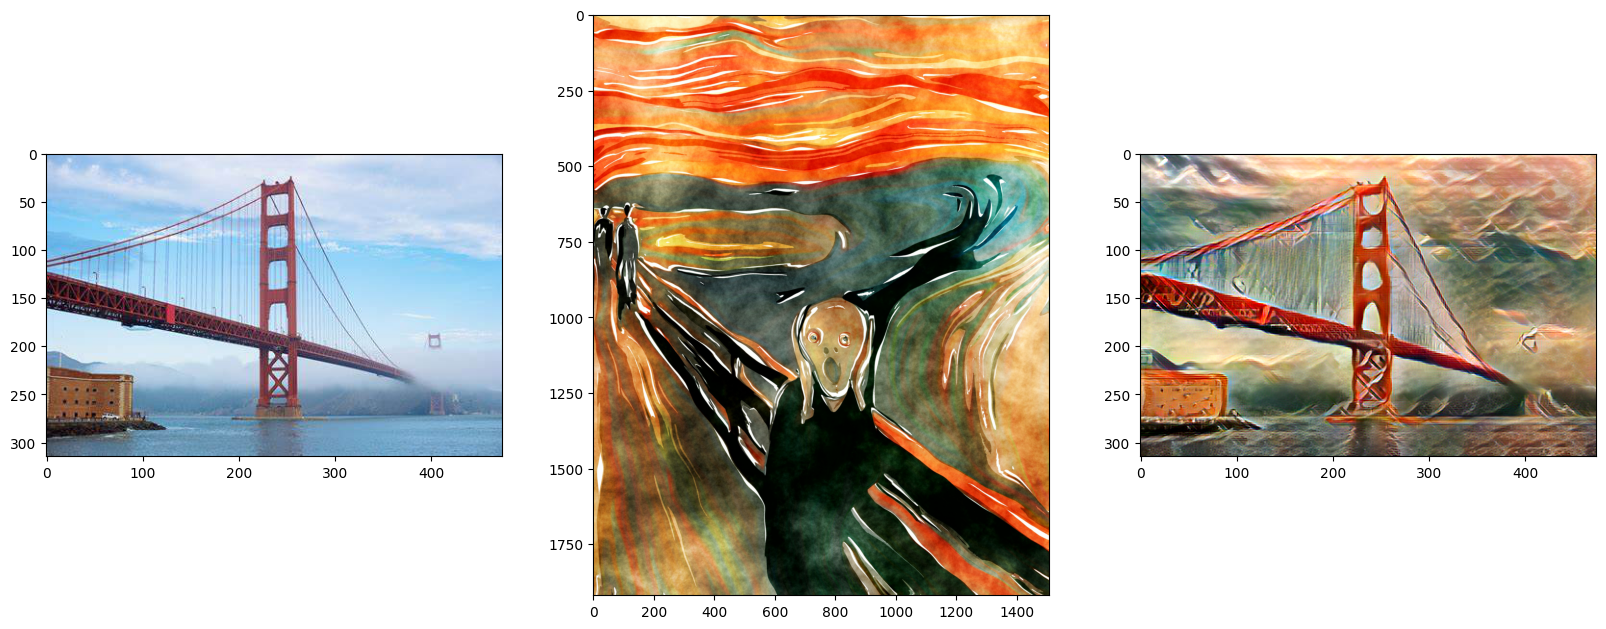

In [35]:
root_c = '/home/louis/NST/NST-Project/content_images'
root_s = '/home/louis/NST/NST-Project/style_images'
files_c = os.listdir(root_c)
files_s = os.listdir(root_s)
idx_c = np.random.randint(0, len(files_c))
idx_s = np.random.randint(0, len(files_s))
path_c = os.path.join(root_c, files_c[idx_c])
path_s = os.path.join(root_s, files_s[idx_s])
device = 'cuda:0'
gen_imag = inference(model.to(device), '/home/louis/NST/NST-Project/content_images/bridge.jpg', '/home/louis/NST/NST-Project/style_images/The_Scream.jpg', device)

In [39]:
save_image(gen_imag, f'out.png')

In [29]:
path_c

'/home/louis/NST/NST-Project/content_images/lake.jpg'

In [30]:
path_s

'/home/louis/NST/NST-Project/style_images/The_Swing.jpg'

# Evaluate our model

In [1]:
import torch
import os
from tqdm import tqdm
from torch import nn
from lossnet import VGG, style_loss, content_loss
from peft import LoraConfig, get_peft_model
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from PIL import Image
from model import NST
from trainer import make_grid, save_image
from encoder import print_trainable_parameters

/home/louis/anaconda3/envs/NST/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def evaluate(model, vgg, content_path, style_path, device):
    # load images
    content_imag = transforms.ToTensor()(Image.open(content_path).convert("RGB"))
    style_imag = transforms.ToTensor()(Image.open(style_path).convert("RGB"))
    # calculate input standard size, since the input should be square images and size should be a multiple of 16
    _, Hc, Wc = content_imag.shape
    style_imag_resize = transforms.Resize((Hc, Wc))(style_imag)
    size = max(Hc, Wc)
    if size % 16 != 0:
        std_size = size + (16 - size % 16)
    else:
        std_size = size
    pad_H = std_size - Hc
    pad_W = std_size - Wc
    # pad the images to be square input
    Ic = nn.ReflectionPad2d([0, pad_W, 0, pad_H])(content_imag).unsqueeze(0).to(device)
    Is = nn.ReflectionPad2d([0, pad_W, 0, pad_H])(style_imag_resize).unsqueeze(0).to(device)
    # resize Ic and Is if std_size too big
    max_size = 512
    if std_size > max_size:
        Ic = transforms.Resize((max_size, max_size))(Ic)
        Is = transforms.Resize((max_size, max_size))(Is)
    # normalize
    normalize = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    Ic = normalize(Ic)
    Is = normalize(Is)
    # generate images
    model.eval()
    with torch.no_grad():
        Ig = model(Ic, Is)
    # inverse the normalization
    inv_normalize = transforms.Compose([ 
        transforms.Normalize(mean = [0., 0., 0.], std = [1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean = [-0.485, -0.456, -0.406], std = [1., 1., 1.]),
    ])
    Ig = inv_normalize(Ig).squeeze(0)
    # resize Ig back if Ic and Is being resized before
    if std_size > max_size:
        Ig = transforms.Resize((std_size, std_size))(Ig)
    # crop the generated images to be of the same size as content_imag
    if pad_H == 0 and pad_W == 0:
        gen_imag = Ig
    elif pad_H == 0 and pad_W != 0:
        gen_imag = Ig[:,:,:-pad_W]
    elif pad_H != 0 and pad_W == 0:
        gen_imag = Ig[:,:-pad_H]
    else:
        gen_imag = Ig[:,:-pad_H, :-pad_W]
    # calculate style loss and content loss
    Is = style_imag_resize.unsqueeze(0).to(device)
    Ic = content_imag.unsqueeze(0).to(device)
    Ig = gen_imag.unsqueeze(0)
    loss_c = content_loss(vgg, Ic, Ig)
    loss_s = style_loss(vgg, Is, Ig)
    return loss_c, loss_s
    


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
vgg = VGG().to(device)
# config
r = 64
target_modules = ["query", "value"]
encoder_num_layers = 6
decoder_num_layers = 3
model_id = '35th'
model_path = '/data/louis/NST_checkpoint/NST_' + model_id + '_jointly_training_best.pth'

# lora config
lora_config_c = LoraConfig(
    r=r,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.1,
    bias="none",
)
lora_config_s = LoraConfig(
    r=r,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.1,
    bias="none",
)
# load the model
model = NST(encoder_num_layers=encoder_num_layers, decoder_num_layers=decoder_num_layers, freeze=True)
model.encoder_c = get_peft_model(model.encoder_c, lora_config_c)
model.encoder_s = get_peft_model(model.encoder_s, lora_config_s)
model.load_state_dict(torch.load(model_path, map_location=device))
# calculate content loss and style loss
loss_s_total = 0.
loss_c_total = 0.
root_c = '/home/louis/NST/NST-Project/content_images'
root_s = '/home/louis/NST/NST-Project/style_images'
files_c = os.listdir(root_c)
files_s = os.listdir(root_s)
for file_c in tqdm(files_c):
    for file_s in files_s:
        content_path = os.path.join(root_c, file_c)
        style_path = os.path.join(root_s, file_s)
        loss_c, loss_s = evaluate(model.to(device), vgg, content_path, style_path, device)
        loss_c_total += loss_c
        loss_s_total += loss_s
total_pairs = len(files_c) * len(files_s)
print(f'{model_id} average content loss: {loss_c_total / total_pairs}')
print(f'{model_id} average style loss: {loss_s_total / total_pairs}')


100%|██████████| 16/16 [04:03<00:00, 15.20s/it]


35th average content loss: 9.183099746704102
35th average style loss: 1.5553252696990967


# Evaluate baselines

In [50]:
def evaluate_baselines(vgg, root_c, root_s, root_g, gen_filename, device):
    # get the content image and style image path
    content_filename, style_filename = gen_filename.split('_stylized_')
    if not content_filename.endswith(('.jpg', '.JPG')):
        if content_filename != 'city5':
            content_filepath = content_filename + '.jpg'
        else:
            content_filepath = content_filename + '.JPG'
    else:
        content_filepath = content_filename
        style_filename = style_filename[:-4]
        if style_filename.endswith('.webp'):
            style_filename = style_filename[:-5] + '.jpg'
    content_path = os.path.join(root_c, content_filepath)
    style_path = os.path.join(root_s, style_filename)
    gen_path = os.path.join(root_g, gen_filename)
    # load images
    content_imag = transforms.ToTensor()(Image.open(content_path).convert("RGB"))
    style_imag = transforms.ToTensor()(Image.open(style_path).convert("RGB"))
    gen_imag = transforms.ToTensor()(Image.open(gen_path).convert("RGB"))
    # resize the style imag and gen_imag into the same shape as content imag
    _, Hc, Wc = content_imag.shape
    style_imag_resize = transforms.Resize((Hc, Wc))(style_imag)
    gen_imag_resize = transforms.Resize((Hc, Wc))(gen_imag)
    # calculate style loss and content loss
    Is = style_imag_resize.unsqueeze(0).to(device)
    Ic = content_imag.unsqueeze(0).to(device)
    Ig = gen_imag_resize.unsqueeze(0).to(device)
    loss_c = content_loss(vgg, Ic, Ig)
    loss_s = style_loss(vgg, Is, Ig)
    # plt.figure(figsize=(10, 10))
    # plt.subplot(1,2,1)
    # plt.imshow(gen_imag.permute(1,2,0))
    # plt.subplot(1,2,2)
    # plt.imshow(Ig.cpu().squeeze(0).permute(1,2,0))
    return loss_c, loss_s
    


In [42]:
files_g = list()
for _, _, filelist in os.walk('/home/louis/NST/NST-Project/compare/MCC'):
    files_g.extend(filelist)
len(files_g)

352

In [44]:
# calculate content loss and style loss
loss_s_total = 0.
loss_c_total = 0.
root_c = '/home/louis/NST/NST-Project/content_images'
root_s = '/home/louis/NST/NST-Project/style_images'

# config
model_id = 'MCC'
root_g = '/home/louis/NST/NST-Project/compare/' + model_id
folders_g = os.listdir(root_g)

for folder in folders_g:
    subroot_g = os.path.join(root_g, folder)
    files_g = os.listdir(subroot_g)
    for file_g in tqdm(files_g):
        loss_c, loss_s = evaluate_baselines(vgg, root_c, root_s, subroot_g, file_g, device)
        loss_c_total += loss_c
        loss_s_total += loss_s

total_pairs = 352
print(f'{model_id} average content loss: {loss_c_total / total_pairs}')
print(f'{model_id} average style loss: {loss_s_total / total_pairs}')

100%|██████████| 22/22 [00:05<00:00,  3.75it/s]


MCC average content loss: 9.204059600830078
MCC average style loss: 2.9450201988220215


In [51]:
# calculate content loss and style loss
loss_s_total = 0.
loss_c_total = 0.
root_c = '/home/louis/NST/NST-Project/content_images'
root_s = '/home/louis/NST/NST-Project/style_images'

# config
model_id = 'SANet'
root_g = '/home/louis/NST/NST-Project/compare/' + model_id
files_g = os.listdir(root_g)

for file_g in tqdm(files_g):
    loss_c, loss_s = evaluate_baselines(vgg, root_c, root_s, root_g, file_g, device)
    loss_c_total += loss_c
    loss_s_total += loss_s

total_pairs = len(files_g)
print(f'{model_id} average content loss: {loss_c_total / total_pairs}')
print(f'{model_id} average style loss: {loss_s_total / total_pairs}')

  0%|          | 0/352 [00:00<?, ?it/s]/home/louis/anaconda3/envs/NST/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 352/352 [03:42<00:00,  1.58it/s]


SANet average content loss: 9.687028884887695
SANet average style loss: 2.53454852104187


(tensor(11.0588, device='cuda:0'), tensor(1.6138, device='cuda:0'))

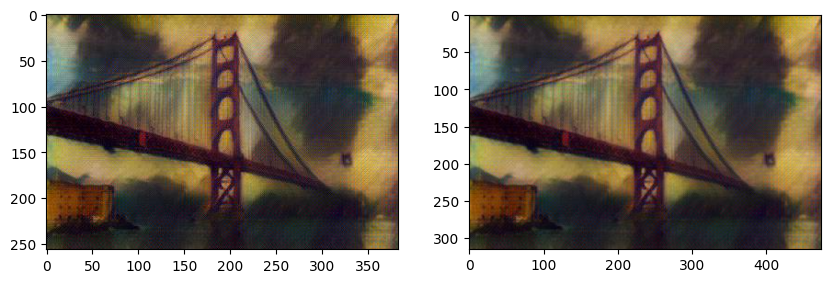

In [29]:
evaluate_baselines(vgg, root_c, root_s, root_g, 'bridge_stylized_Mona_Lisa.jpg', device)